# Plot Distribution of $g(x)$ at Coexistencde

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

final_fig_path = "../CH_Manuscript/Figures/"
import sys
sys.path.insert(1, 'Functions')
from bif_diagram_funs import get_bif_input
from group_w_pop_funs import update_params
from sim_graph_funs import param_lab_dic, colors, format_ax
figure_ops = dict(bbox_inches = 'tight', format = 'eps', dpi=300, transparent=False)
final_fig_path = "../CH_Manuscript/Figures/"


CONSIDER CALCULATING PROBABILITY OF GROUP MEMBERSHIP

In [2]:
# def get_coexistence_g_values(df, param_key, param_vec, x_max, include_unstable=True):
#     """
#     Function to find the coexistence g(x) values for each scale value when A1 is fixed.

#     Arguments:
#     include_unstable : bool
#         Whether to include unstable coexistence equilibria if no stable ones exist.
#     df : DataFrame
#         DataFrame containing the equilibrium data.

#     Returns:
#     g_values_matrix : 2D array
#         Matrix of g(x) values for each scale and group size (x).
#     """
#     def fill_g(i):
#         for x in range(1, x_max + 1):
#             g_values_matrix[i, x-1] = stable_coexistence[f'g{x}'].values[0]
#     # Filter the dataframe for the specific A1 value

#     # Initialize the matrix for storing g(x) values
#     g_values_matrix = np.full((len(param_vec), x_max), np.nan)
    
#     for i, param in enumerate(param_vec):
#         subset = df[df[param_key] == param]
        
#         # Get the coexistence equilibria for the given scale
#         coexistence = subset[subset["equilibrium_type"] == "Coexistence"]
        
#         if not coexistence.empty:
#             # Check for stable coexistence
#             stable_coexistence = coexistence[coexistence["stability"] == "Stable (attractive)"]
#             if not stable_coexistence.empty:
#                 # Use the stable coexistence equilibrium's g(x) values
#                 fill_g(i)
#             elif include_unstable:
#                 # Otherwise, use unstable coexistence if available
#                 unstable_coexistence = coexistence[coexistence["stability"] == "Unstable"]
#                 if not unstable_coexistence.empty:
#                     predator_extinct = subset[subset["equilibrium_type"] == "Predator Extinct"]
#                     if predator_extinct.empty or (predator_extinct["stability"] == "Unstable").all():
#                         fill_g(i)
                    
#     return g_values_matrix

def get_coexistence_probx_value(df, param_key, param_vec, 
                                        x_max, include_unstable=True):
    """
    Function to find the coexistence probability that a predator is in a group of size x
    for each value in param_vec.

    Arguments:
    include_unstable : bool
        Whether to include unstable coexistence equilibria if no stable ones exist.
    df : DataFrame
        DataFrame containing the equilibrium data.

    Returns:
    g_values_matrix : 2D array
        Matrix of g(x) values for each scale and group size (x).
    """
    def fill_prob_x(i, coexistence_df):
        for x in range(1, x_max + 1):
            g_val = coexistence_df[f'g{x}'].values[0]
            prob_x_values_matrix[i, x-1] = x*g_val/coexistence_df['p'].values[0]
    # Filter the dataframe for the specific A1 value

    # Initialize the matrix for storing g(x) values
    prob_x_values_matrix = np.full((len(param_vec), x_max), np.nan)
    
    for i, param in enumerate(param_vec):
        subset = df[df[param_key] == param]
        
        # Get the coexistence equilibria for the given scale
        coexistence = subset[subset["equilibrium_type"] == "Coexistence"]
        
        if not coexistence.empty:
            # Check for stable coexistence
            stable_coexistence = coexistence[coexistence["stability"] == "Stable (attractive)"]
            if not stable_coexistence.empty and stable_coexistence['p'].values[0]>1e-8:
                # Use the stable coexistence equilibrium's g(x) values
                fill_prob_x(i, stable_coexistence)
            elif include_unstable:
                # Otherwise, use unstable coexistence if available
                unstable_coexistence = coexistence[coexistence["stability"] == "Unstable"]
                if not unstable_coexistence.empty:
                    predator_extinct = subset[subset["equilibrium_type"] == "Predator Extinct"]
                    if predator_extinct.empty or (predator_extinct["stability"] == "Unstable").all():
                        fill_prob_x(i, unstable_coexistence)
                    
    return prob_x_values_matrix
def plot_prob_values(df, param_key, param_vec, x_max, include_unstable = True):
    prob_values_matrix = get_coexistence_probx_value(df, param_key, param_vec,
                                                 x_max,include_unstable)
    # Create the heatmap plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Define colormap with vcenter as median of g_values_matrix (grayscale)
    divnorm = mcolors.TwoSlopeNorm(vmin=0, 
                                   vmax=np.nanmax(prob_values_matrix), 
                                   vcenter=0.5*np.nanmax(prob_values_matrix))
    
    
    # Use meshgrid to create a grid for the axes
    scale_grid, x_grid = np.meshgrid(param_vec, np.arange(1, x_max + 1))
    
    # Plot the heatmap
    c = ax.pcolormesh(scale_grid, x_grid, prob_values_matrix.T, 
                      shading='auto', cmap='Grays', norm=divnorm)
    
    # Add colorbar
    c= fig.colorbar(c, ax=ax, label='prob(x) Values')
    c.set_label(label='prob(x) Values', fontsize = 20)
    
    # Labels and title
    ax.set_xlabel(param_lab_dic[param_key], fontsize = 20)
    ax.set_ylabel('Group Size (x)', fontsize = 20)
    
    return fig, ax, prob_values_matrix
    

# Type II, $H_1$, $\beta_1$, $\eta_1$ scaled, vary scale

In [3]:
H = 1
x_max = 5
params_base = dict(η1 = 0.2, η2 = 0.6, A1 = 0.6, A2 = 0.5, 
                   β1 = 8, β2 = 1, H1a = 0, H1b=H, H2a = 0, H2b = H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = x_max, d = 10,scale = 1.5,
                 Tx = .01, pop_process = True)
params_base = update_params(params_base = params_base, param_key = 'scale', param = 1.5)

In [4]:
param_key = 'scale'; param_vec = np.linspace(1.5,13,30);


df_scale = get_bif_input(param_key, param_vec, params_base, num_init = 25, 
                      num_perturbations = 2,
                          perturb_strength = 0.02,t_f = 1100)

/Users/taliaborofsky/Documents/CH_GroupFormation/CH_code/Functions/group_w_pop_funs.py:375: RuntimeWarning: invalid value encountered in divide
  u_ = y_/(b*y0) # find derivative of transformed coordinates


In [39]:
df_scale['scale'].unique()

array([ 1.5       ,  1.89655172,  2.29310345,  2.68965517,  3.0862069 ,
        3.48275862,  3.87931034,  4.27586207,  4.67241379,  5.06896552,
        5.46551724,  5.86206897,  6.25862069,  6.65517241,  7.05172414,
        7.44827586,  8.24137931,  8.63793103,  9.03448276,  9.43103448,
        9.82758621, 10.22413793, 10.62068966, 11.01724138, 11.4137931 ,
       11.81034483, 12.20689655, 12.60344828, 13.        ,  7.84482759])

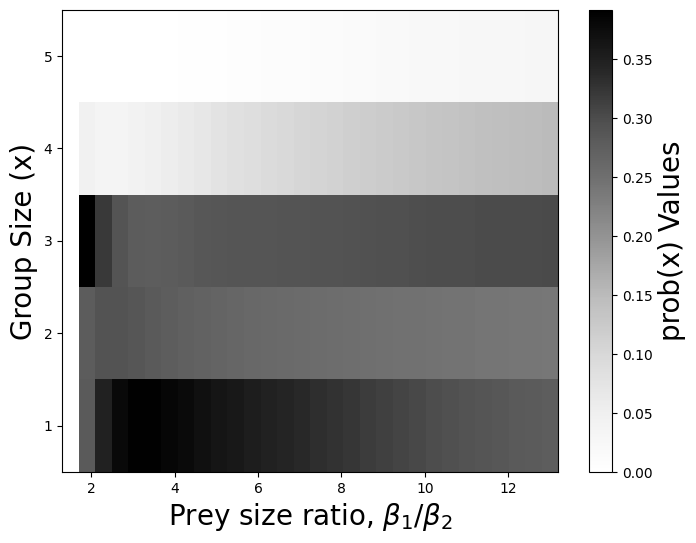

In [75]:
fig, ax, prob_values_mat = plot_prob_values(df_scale, param_key, param_vec, x_max, include_unstable = False)

In [7]:
fig.savefig(final_fig_path + 'distribution_massratio.eps', **figure_ops)

In [44]:
prob_vec

array([[0.37727192, 0.2738475 , 0.28269918, 0.06277178, 0.00340962]])

In [ ]:
val = 1.89


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[1.89655172]


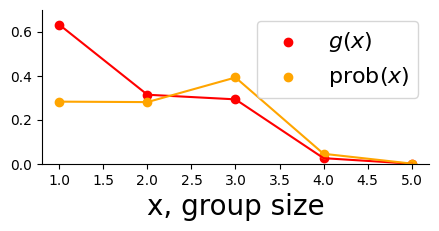

In [92]:
# for scale = 1.89ish, plot g(x) and prob(x)
plt.figure(figsize=(5,2))
g = df_scale.query('abs(scale - 1.89) < .01').values[0,3:8]
plt.plot([1,2,3,4,5],g, color = colors[0])
plt.scatter([1,2,3,4,5],g, color = colors[0],label = r'$g(x)$')

param_mask = np.isclose(param_vec, 1.89,1e-2)
prob_vec = prob_values_mat[param_mask][0]
plt.plot([1,2,3,4,5], prob_vec, color = colors[1])
plt.scatter([1,2,3,4,5],prob_vec, color = colors[1],label = r'prob$(x)$')
format_ax(ax=plt.gca(), xlab = 'x, group size', ylab = '', ylim = [0,0.7],
          if_legend=True)
print(param_vec[param_mask])
#prob_x = [x*g[x-1]/
plt.savefig(final_fig_path + 'distribution_scale_189.eps', **figure_ops)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[3.48275862]


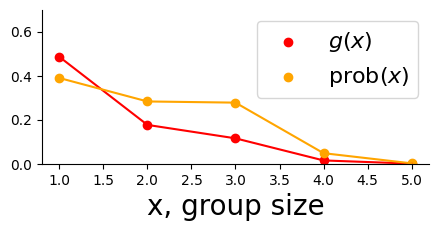

In [93]:
# for scale = 3.48ish, plot g(x) and prob(x)
plt.figure(figsize=(5,2))

g = df_scale.query('abs(scale - 3.48) < .01').values[0,3:8]
plt.plot([1,2,3,4,5],g, color = colors[0])
plt.scatter([1,2,3,4,5],g, color = colors[0],label = r'$g(x)$')

param_mask = np.isclose(param_vec, 3.48,1e-2)
prob_vec = prob_values_mat[param_mask][0]
plt.plot([1,2,3,4,5], prob_vec, color = colors[1])
plt.scatter([1,2,3,4,5],prob_vec, color = colors[1],label = r'prob$(x)$')
format_ax(ax=plt.gca(), xlab = 'x, group size', ylab = '', ylim = [0,0.7],if_legend=True)
print(param_vec[param_mask])
#prob_x = [x*g[x-1]/
plt.savefig(final_fig_path + 'distribution_scale_348.eps', **figure_ops)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[7.44827586]


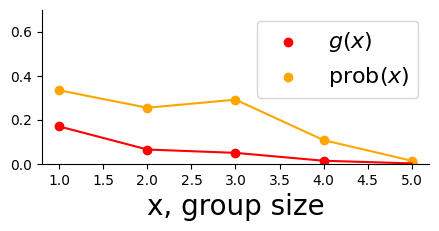

In [94]:
# for scale = 7ish, plot g(x) and prob(x)
plt.figure(figsize=(5,2))

val = 7.44
g = df_scale.query('abs(scale - 7.44) < .01').values[0,3:8]
plt.plot([1,2,3,4,5],g, color = colors[0])
plt.scatter([1,2,3,4,5],g, color = colors[0],label = r'$g(x)$')

param_mask = np.isclose(param_vec, val,1e-2)
prob_vec = prob_values_mat[param_mask][0]
plt.plot([1,2,3,4,5], prob_vec, color = colors[1])
plt.scatter([1,2,3,4,5],prob_vec, color = colors[1],label = r'prob$(x)$')
format_ax(ax=plt.gca(), xlab = 'x, group size', ylim = [0,0.7],ylab = '', if_legend=True)

#prob_x = [x*g[x-1]/
print(param_vec[param_mask])
plt.savefig(final_fig_path + 'distribution_scale_744.eps', **figure_ops)

In [8]:
df_scale.columns

Index(['scale', 'N1', 'N2', 'g1', 'g2', 'g3', 'g4', 'g5', 'p', 'mean_x', 'var',
       'equilibrium_type', 'stability'],
      dtype='object')

# Type II, Scaled, Vary $\eta_2$

In [4]:
H = 1
x_max = 5
scale = 6
params_base = dict(η1 = 0.2, η2 = 0.6, A1 = 0.6, A2 = 0.5, 
                   β1 = 8, β2 = 1, H1a = 0, H1b=H, H2a = 0, H2b = H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = x_max, d = 10,
                 Tx = .01, pop_process = True, scale = 6)
params = update_params(param_key = "scale", param=scale, params_base=params_base)

In [5]:

param_key = 'η2'

param_vec = np.linspace(0.2,scale/(scale + 1),30)
df = get_bif_input(param_key, param_vec, params, num_init = 25, 
                      num_perturbations = 4,
                          perturb_strength = 0.01,t_f = 1100)


/Users/taliaborofsky/Documents/CH_GroupFormation/CH_code/Functions/group_w_pop_funs.py:375: RuntimeWarning: invalid value encountered in divide
  u_ = y_/(b*y0) # find derivative of transformed coordinates


ValueError: too many values to unpack (expected 2)

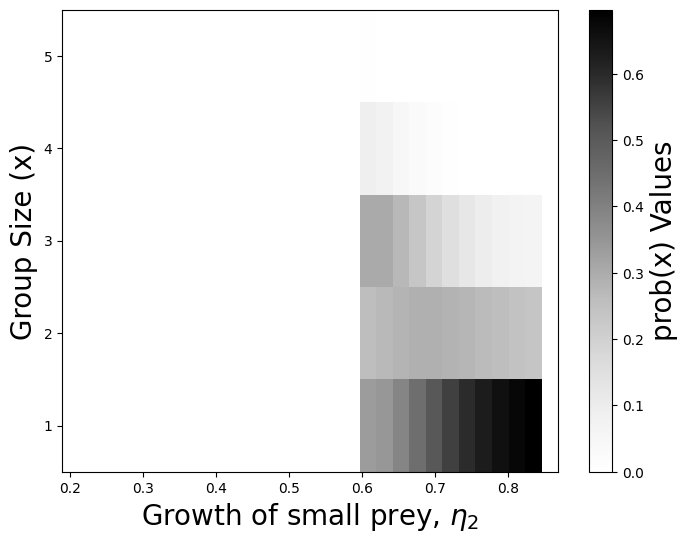

In [6]:
fig, ax = plot_prob_values(df, param_key, param_vec, x_max, include_unstable = False)

In [19]:
predator_extinct

,η1,N1,N2,g1,g2,g3,g4,g5,p,mean_x,var,equilibrium_type,stability
243,0.347241,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Predator Extinct,Unstable
244,0.347241,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Predator Extinct,Unstable
245,0.347241,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Predator Extinct,Unstable


In [ ]:
        subset = df[df[param_key] == param]
        
        # Get the coexistence equilibria for the given scale
        coexistence = subset[subset["equilibrium_type"] == "Coexistence"]
        
        if not coexistence.empty:
            # Check for stable coexistence
            stable_coexistence = coexistence[coexistence["stability"] == "Stable (attractive)"]
            if not stable_coexistence.empty and stable_coexistence['p'].values[0]>1e-8:
                # Use the stable coexistence equilibrium's g(x) values
                fill_prob_x(i)
            elif include_unstable:
                # Otherwise, use unstable coexistence if available
                unstable_coexistence = coexistence[coexistence["stability"] == "Unstable"]
                if not unstable_coexistence.empty:
                    predator_extinct = subset[subset["equilibrium_type"] == "Predator Extinct"]
                    if predator_extinct.empty or (predator_extinct["stability"] == "Unstable").all():
                        fill_prob_x(i)